In [10]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt;

In [213]:
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [265]:
def graphs(input_gdp, input_potential, input_gap, input_type):
      
    plt.figure()
    input_potential.divide(input_potential.iloc[0] / 100).plot(figsize=(20, 10), colormap="tab20")
    plt.title(input_type + " Approach: Potential GDP of EU Countries", fontsize=20)
    plt.ylabel("Potential GDP")
    plt.xlabel("Date, Years")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

    plt.figure()
    ((input_gap.divide(input_gdp)*100)).plot(figsize=(20, 10), colormap="tab20")
    plt.title(input_type+" Approach: GDP Gaps of EU Countries", fontsize=20)
    plt.ylabel("GDP Gap, \%")
    plt.xlabel("Date, Years")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()
    
    f, ax = plt.subplots(figsize=(10, 10))
    corr = input_gap.corr()
    sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax)
    plt.show()

<br>

## $\textrm{Data}$

$ \textbf{HWCDW} \ \textrm{Nominal compensation per employee: total economy (HWCDW) - 1000CU }$

$ \textbf{NLTN} \ \textrm{Total labour force (Labour force statistics) (NLTN) - 1000 persons }$

$ \textbf{OKND} \ \textrm{Net capital stock at 2010 prices: total economy (OKND) - Mrd CU }$

$ \textbf{OVGD} \ \textrm{Gross domestic product at 2010 reference levels (OVGD) - Mrd CU }$

$ \textbf{UVGE} \ \textrm{Gross value added at current basic prices excluding FISIM: total economy (UVGE) - Mrd CU }$

$ \textbf{ZUTN} \ \textrm{Unemployment rate: total :- Member States: definition EUROSTAT (ZUTN) - (Percentage of active population)  }$


In [222]:
study_countries = ["Austria", "Belgium", "Cyprus", "Estonia", "Finland", "France", "Germany", 
                   "Greece", "Ireland", "Italy", "Latvia", "Lithuania", "Luxembourg", "Malta", 
                   "Netherlands", "Portugal", "Slovakia", "Slovenia", "Spain"]

In [226]:
def data_handling(data_source, study_countries):
    study_indicators = list(set(data_source.Indicator))
    study_years = [str(i) for i in range(1960, 2020)]
    
    counter = 0
    col = ["country", "year"]; col.extend(study_indicators)
    output = pd.DataFrame(index=col)
    
    for country in study_countries:
        for year in study_years:
            counter += 1
            indicators = [data_source[(data_source.Country == country) & (data_source.Indicator == indicator)][year].values[0] for indicator in study_indicators]
            row_values = [country, int(year)]; row_values.extend(indicators)
            output[counter] = row_values
    
    output_corrected = output.transpose().copy()
    output_corrected.HWCDW *= 1000
    output_corrected.NLTN *= 1000
    output_corrected.OKND *= 10**9
    output_corrected.OVGD *= 10**9
    output_corrected.UVGE *= 10**9
    output_corrected.ZUTN /= 100
    
    return(output_corrected, study_countries, study_indicators)

In [227]:
source = pd.read_csv("./data_source.csv")
data, countries, indicators = data_handling(source, study_countries)

<br>

## $\textrm{Statistical}$

In [251]:
def statistical(data_input):
    data_input=data_input[data_input.year >= 1995]
    
    study_countries = list(set(data_input.country))
    study_years = [i for i in range(1995, 2020)]
    
    output_trend = pd.DataFrame(index=study_years)
    output_cycle = output_trend.copy()
    
    for country in study_countries:
        country_series = data_input[data_input.country == country].OVGD.values
        cycle, trend = sm.tsa.filters.hpfilter(country_series, 1600)
        
        output_trend[country] = trend
        output_cycle[country] = cycle
            
    return((output_trend+output_cycle).dropna(axis=1).astype(float), output_trend.dropna(axis=1).astype(float), output_cycle.dropna(axis=1).astype(float))

In [252]:
statistical_gdp, statistical_potential, statistical_gap = statistical(data)

<Figure size 432x288 with 0 Axes>

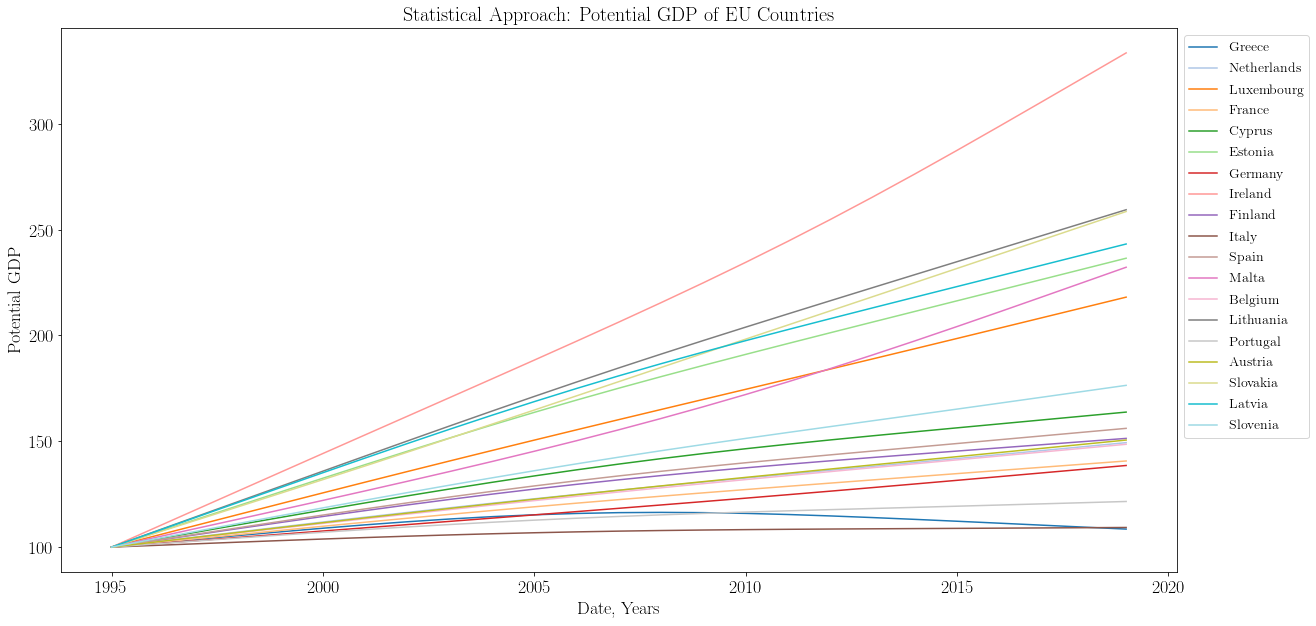

<Figure size 432x288 with 0 Axes>

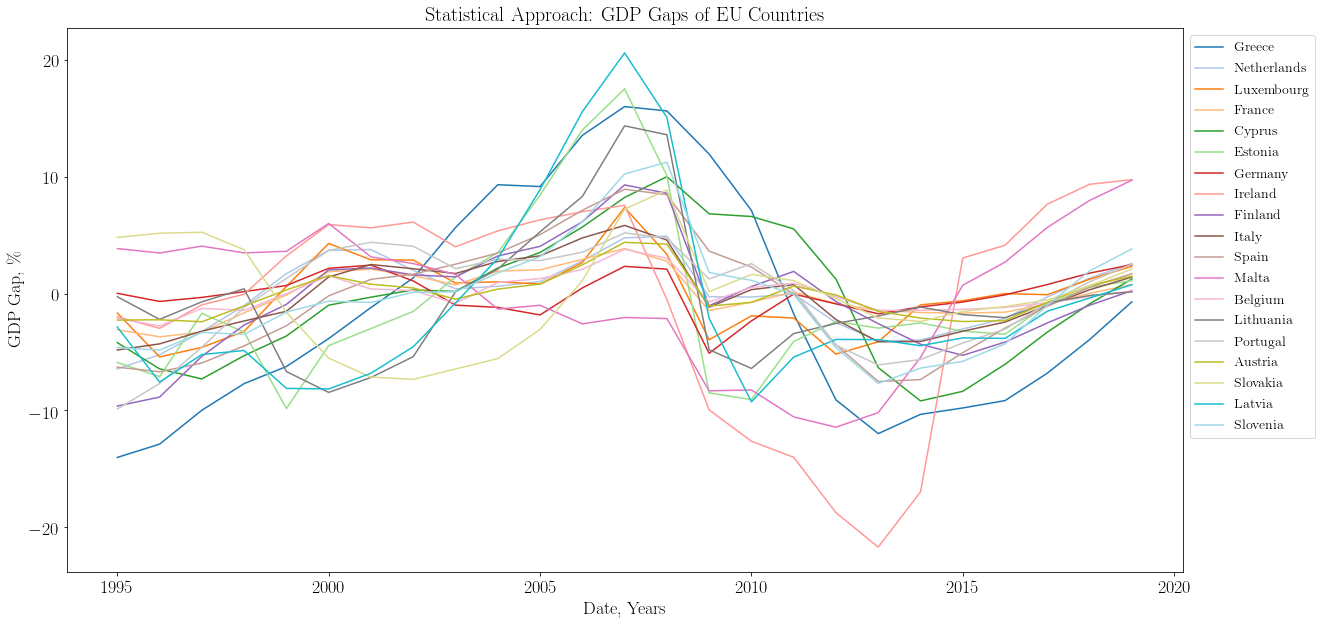

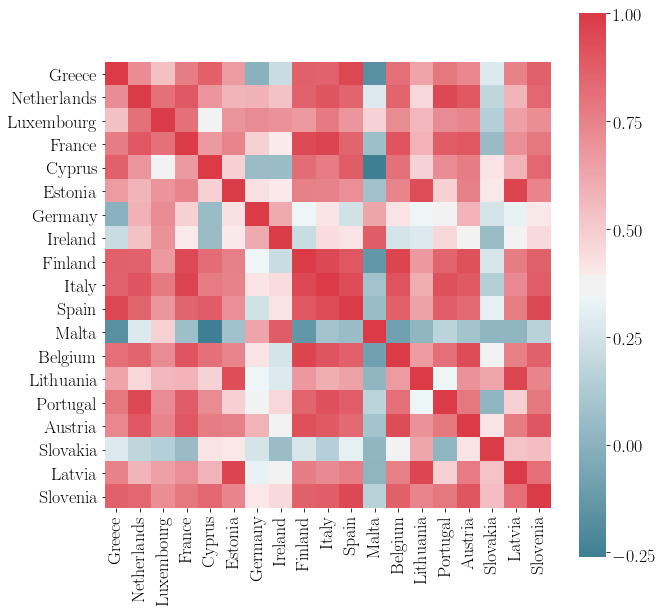

In [266]:
graphs(statistical_gdp, statistical_potential, statistical_gap, "Statistical")

<br>

## $\textrm{Structural}$

In [232]:
def structural(data_input):
    study_countries = list(set(data_input.country))
    study_years = [i for i in range(1995, 2020)]
    study_indicators = ["year", "HWCDW", "NLTN", "OKND", "OVGD", "UVGE", "ZUTN"]
    
    output_trend = pd.DataFrame(index=study_years)
    output_cycle = output_trend.copy()
    
    data_input=data_input[data_input.year >= 1995]
    
    for country in study_countries:
        
        country_indicators = pd.DataFrame()
        for indicator in study_indicators:
            country_indicators[indicator] = data_input[data_input.country == country][indicator]
        country_indicators = country_indicators.set_index("year")

        # Calculate α
        country_indicators["α"] = - (country_indicators["HWCDW"]*(-country_indicators["ZUTN"]+1)*country_indicators["NLTN"])/country_indicators["UVGE"]+1
        
        # Calculate TFP
        country_indicators["TFP"] = country_indicators["OVGD"]/(country_indicators["OKND"].pow(country_indicators["α"])*
                                                                ((-country_indicators["ZUTN"]+1)*country_indicators["NLTN"]).pow(-country_indicators["α"]+1))
        
        # Calculate natural rate of unemployment
        _, country_indicators["NRU"] = sm.tsa.filters.hpfilter(country_indicators["ZUTN"].values, 1600)
        
        # Calculate trend and gap
        output_trend[country] = country_indicators["TFP"]*(country_indicators["OKND"].pow(country_indicators["α"])*
                                                           (country_indicators["NLTN"]*(-country_indicators["NRU"]+1)).pow(-country_indicators["α"]+1))
        
        output_cycle[country] = country_indicators["OVGD"]-output_trend[country]
            
    return((output_trend+output_cycle).dropna(axis=1).astype(float), output_trend.dropna(axis=1).astype(float), output_cycle.dropna(axis=1).astype(float))

In [233]:
structural_gdp, structural_potential, structural_gap = structural(data)

<Figure size 432x288 with 0 Axes>

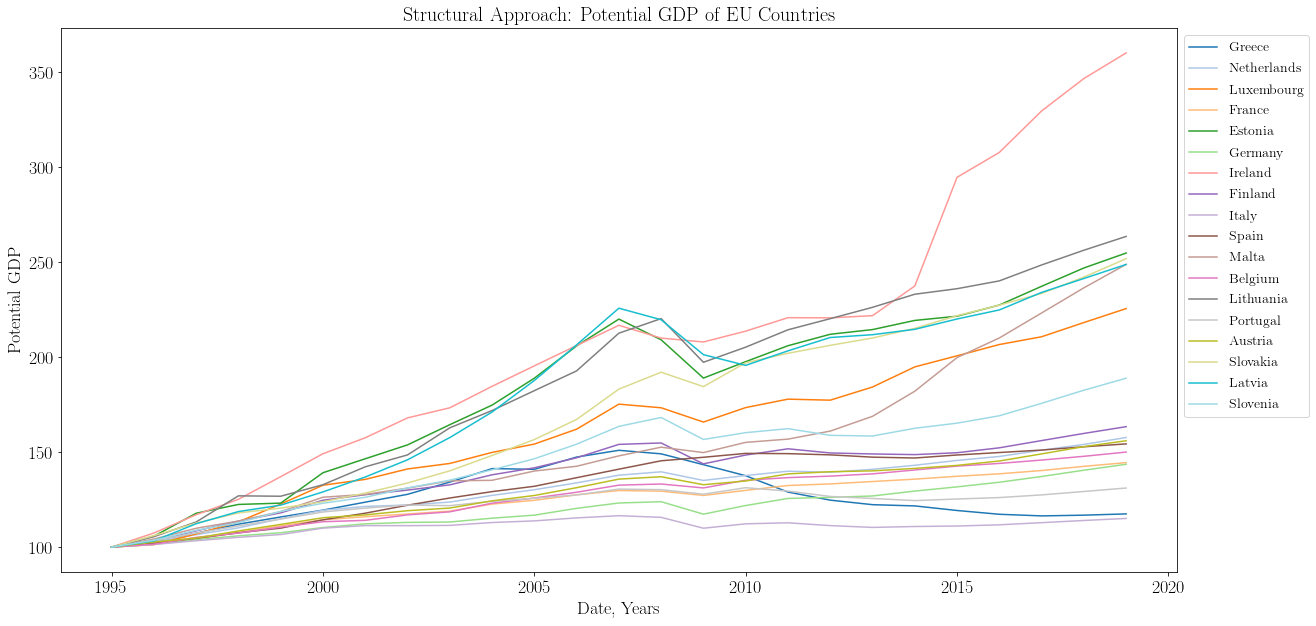

<Figure size 432x288 with 0 Axes>

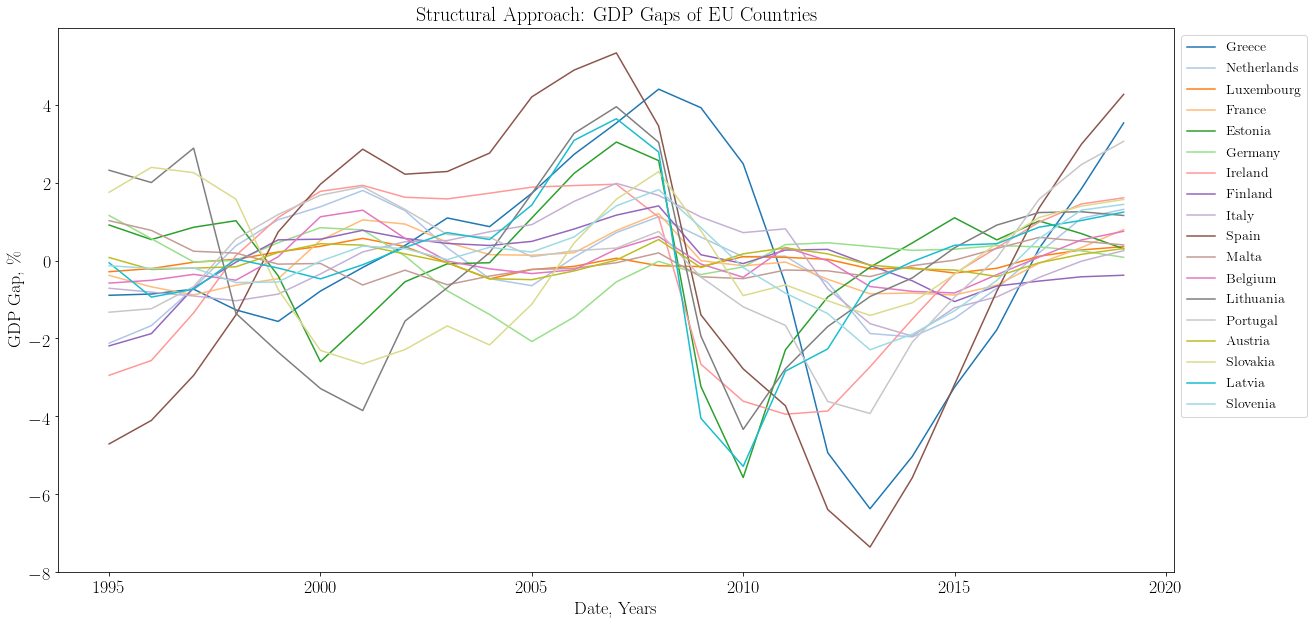

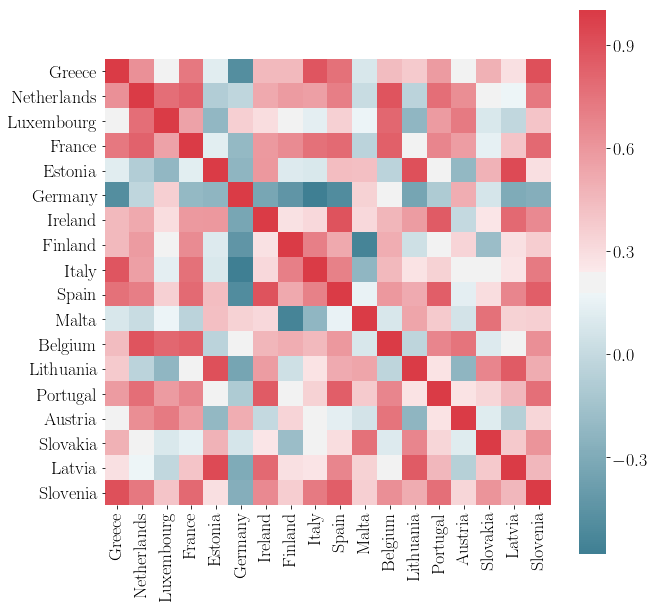

In [267]:
graphs(structural_gdp, structural_potential, structural_gap, "Structural")

<br>